In [30]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gunavenkatdoddi/eye-diseases-classification")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/eye-diseases-classification


In [31]:
# ========================================
# STEP 1: IMPORT LIBRARIES
# ========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3, ResNet50, DenseNet121
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [32]:
# ========================================
# STEP 2: SET BASE PATH & LOAD DATASET
# ========================================
# Set your dataset path here
BASE_PATH = '/kaggle/input/eye-diseases-classification/dataset'

# Get class names and SORT them to ensure consistent order
classes = os.listdir(BASE_PATH)
classes = [c for c in classes if os.path.isdir(os.path.join(BASE_PATH, c))]
classes = sorted(classes)  # IMPORTANT: Sort alphabetically for consistency
print(f"Classes found: {classes}")
print(f"Number of classes: {len(classes)}")

# Create class to index mapping
class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}
print(f"Class mapping: {class_to_idx}")

Classes found: ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']
Number of classes: 4
Class mapping: {'cataract': 0, 'diabetic_retinopathy': 1, 'glaucoma': 2, 'normal': 3}



Total images: 4217


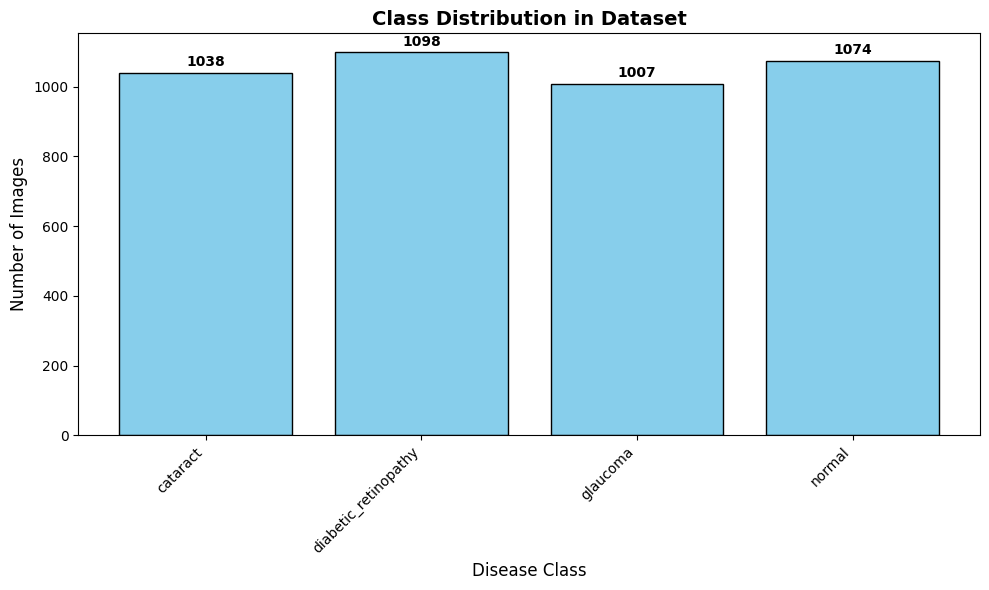

In [33]:
# ========================================
# STEP 3: CLASS DISTRIBUTION VISUALIZATION
# ========================================
class_counts = {}
all_image_paths = []
all_labels = []

for idx, class_name in enumerate(classes):
    class_path = os.path.join(BASE_PATH, class_name)
    images = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
    class_counts[class_name] = len(images)
    
    for img_name in images:
        all_image_paths.append(os.path.join(class_path, img_name))
        all_labels.append(idx)

print(f"\nTotal images: {len(all_image_paths)}")

# Plot class distribution
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue', edgecolor='black')
plt.xlabel('Disease Class', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title('Class Distribution in Dataset', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
for i, (k, v) in enumerate(class_counts.items()):
    plt.text(i, v + 20, str(v), ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

In [34]:
# ========================================
# STEP 4: SPLIT DATASET (70-15-15)
# ========================================
X_temp, X_test, y_temp, y_test = train_test_split(
    all_image_paths, all_labels, test_size=0.15, random_state=42, stratify=all_labels
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp  # 0.176 of 85% ≈ 15% of total
)

print(f"\nDataset split:")
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")


Dataset split:
Training samples: 2953
Validation samples: 631
Test samples: 633


In [35]:
# ========================================
# STEP 5: IMAGE LOADING & PREPROCESSING
# ========================================
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = len(classes)

def load_and_preprocess_image(image_path, label):
    # Read image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.keras.applications.efficientnet.preprocess_input(img)  # EfficientNet preprocessing
    return img, label

# Create datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_ds = val_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("\nDatasets created successfully!")


Datasets created successfully!


In [36]:
# ========================================
# STEP 6: DATA AUGMENTATION
# ========================================
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

# Apply augmentation to training data
def augment_data(image, label):
    return data_augmentation(image, training=True), label

train_ds_augmented = train_ds.map(augment_data, num_parallel_calls=tf.data.AUTOTUNE)

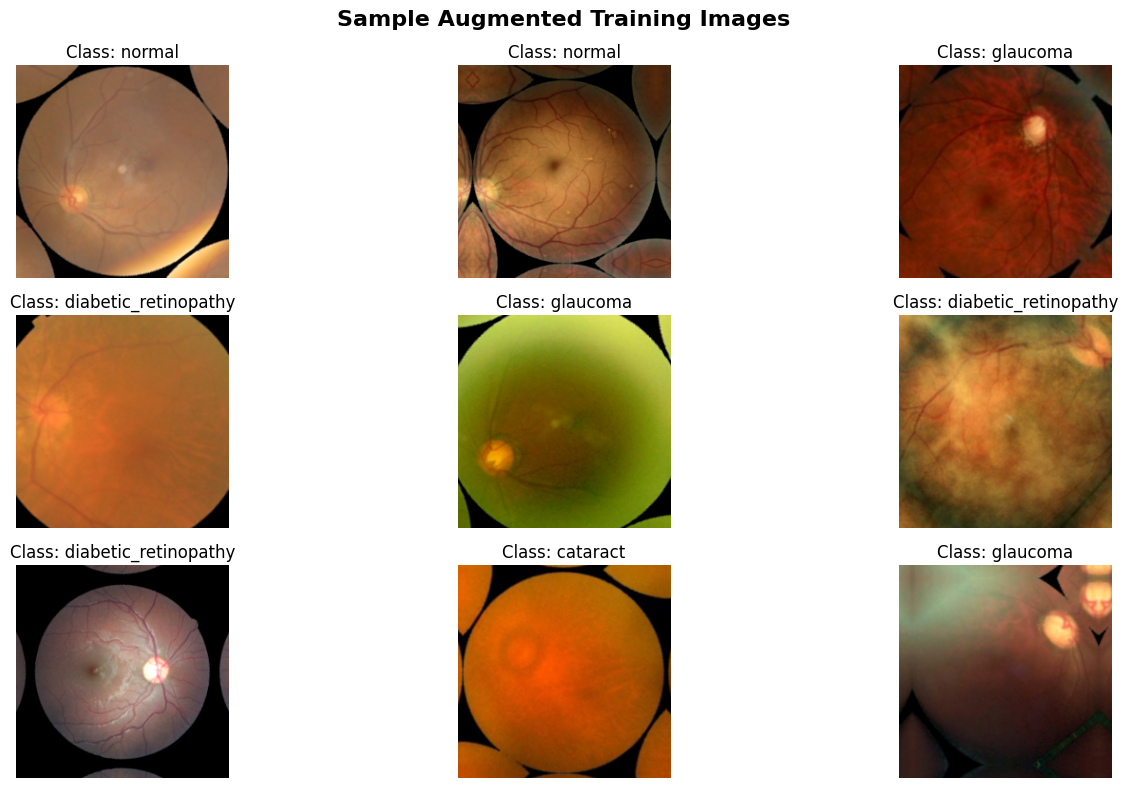

In [37]:
# ========================================
# STEP 7: VISUALIZE AUGMENTED SAMPLES
# ========================================
plt.figure(figsize=(15, 8))
for images, labels in train_ds_augmented.take(1):
    for i in range(min(9, len(images))):
        ax = plt.subplot(3, 3, i + 1)
        # Denormalize for visualization
        img = images[i].numpy()
        img = (img - img.min()) / (img.max() - img.min())
        plt.imshow(img)
        plt.title(f"Class: {classes[labels[i]]}")
        plt.axis("off")
plt.suptitle("Sample Augmented Training Images", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [38]:
# ========================================
# STEP 8: BUILD MODELS
# ========================================
def build_model(base_model_func, model_name):
    base_model = base_model_func(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    
    # Freeze base model
    base_model.trainable = False
    
    # Build model
    inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
    
    model = keras.Model(inputs, outputs, name=model_name)
    return model, base_model

# Create three models
model1, base1 = build_model(EfficientNetB3, "EfficientNetB3")
model2, base2 = build_model(ResNet50, "ResNet50")
model3, base3 = build_model(DenseNet121, "DenseNet121")

models_dict = {
    "EfficientNetB3": (model1, base1),
    "ResNet50": (model2, base2),
    "DenseNet121": (model3, base3)
}

print("\nModels created successfully!")


Models created successfully!


In [39]:
# ========================================
# STEP 9: TRAIN MODELS
# ========================================
EPOCHS = 50
results = {}

for model_name, (model, base_model) in models_dict.items():
    print(f"\n{'='*50}")
    print(f"Training {model_name}")
    print(f"{'='*50}")
    
    # Compile model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
    checkpoint = ModelCheckpoint(
        f'best_{model_name}.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1)
    
    # Train
    history = model.fit(
        train_ds_augmented,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=[early_stop, checkpoint, reduce_lr],
        verbose=1
    )
    
    # Fine-tuning phase
    print(f"\n--- Fine-tuning {model_name} ---")
    base_model.trainable = True
    # Freeze first 80% of layers
    for layer in base_model.layers[:int(len(base_model.layers) * 0.8)]:
        layer.trainable = False
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    history_fine = model.fit(
        train_ds_augmented,
        validation_data=val_ds,
        epochs=30,
        callbacks=[early_stop, checkpoint, reduce_lr],
        verbose=1
    )
    
    # Combine histories
    for key in history.history.keys():
        history.history[key].extend(history_fine.history[key])
    
    # Evaluate on test set
    test_loss, test_acc = model.evaluate(test_ds, verbose=0)
    
    results[model_name] = {
        'history': history.history,
        'test_accuracy': test_acc,
        'test_loss': test_loss,
        'model': model
    }
    
    print(f"\n{model_name} Test Accuracy: {test_acc*100:.2f}%")


Training EfficientNetB3
Epoch 1/50


I0000 00:00:1765559920.053706     172 service.cc:148] XLA service 0x7a808bff2250 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765559920.055060     172 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1765559923.334291     172 cuda_dnn.cc:529] Loaded cuDNN version 90300


 3/93 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.2674 - loss: 1.4992 

I0000 00:00:1765559938.432552     172 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.5494 - loss: 1.0343
Epoch 1: val_accuracy improved from -inf to 0.64501, saving model to best_EfficientNetB3.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 89s 555ms/step - accuracy: 0.5503 - loss: 1.0328 - val_accuracy: 0.6450 - val_loss: 0.8511 - learning_rate: 0.0010
Epoch 2/50
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.7172 - loss: 0.6769
Epoch 2: val_accuracy improved from 0.64501 to 0.67670, saving model to best_EfficientNetB3.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 23s 204ms/step - accuracy: 0.7176 - loss: 0.6763 - val_accuracy: 0.6767 - val_loss: 0.8025 - learning_rate: 0.0010
Epoch 3/50
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.7439 - loss: 0.6555
Epoch 3: val_accuracy improved from 0.67670 to 0.69414, saving model to best_EfficientNetB3.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 23s 203ms/step - accuracy: 0.7440 - loss: 0.6552 - val_accuracy: 0.6941 - val_loss: 0.9106 - learning_rate: 0.0010
Epoch 4/50
92/93 ━━━━━━━━━━━━━━━━━━━

E0000 00:00:1765560604.499324     171 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765560604.716806     171 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765560605.114078     171 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765560605.331398     171 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765560605.902310     171 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.7452 - loss: 0.7729

E0000 00:00:1765560642.537516     171 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765560642.753318     171 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765560643.116203     171 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765560643.332057     171 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765560643.814999     171 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.7455 - loss: 0.7717
Epoch 1: val_accuracy did not improve from 0.78288
93/93 ━━━━━━━━━━━━━━━━━━━━ 104s 561ms/step - accuracy: 0.7458 - loss: 0.7706 - val_accuracy: 0.7528 - val_loss: 0.6017 - learning_rate: 1.0000e-04
Epoch 2/30
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.8322 - loss: 0.4656
Epoch 2: val_accuracy did not improve from 0.78288
93/93 ━━━━━━━━━━━━━━━━━━━━ 22s 195ms/step - accuracy: 0.8324 - loss: 0.4650 - val_accuracy: 0.7670 - val_loss: 0.5675 - learning_rate: 1.0000e-04
Epoch 3/30
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.8710 - loss: 0.3747
Epoch 3: val_accuracy improved from 0.78288 to 0.78447, saving model to best_EfficientNetB3.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 23s 205ms/step - accuracy: 0.8709 - loss: 0.3745 - val_accuracy: 0.7845 - val_loss: 0.5537 - learning_rate: 1.0000e-04
Epoch 4/30
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.8691 - loss: 0.3558
Epoch 4: val_accuracy improv

In [40]:
# ========================================
# STEP 10: MODEL COMPARISON
# ========================================
print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)

comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Test Accuracy': [results[m]['test_accuracy']*100 for m in results.keys()],
    'Test Loss': [results[m]['test_loss'] for m in results.keys()]
})
comparison_df = comparison_df.sort_values('Test Accuracy', ascending=False)
print(comparison_df.to_string(index=False))

# Find best model
best_model_name = comparison_df.iloc[0]['Model']
print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   Test Accuracy: {comparison_df.iloc[0]['Test Accuracy']:.2f}%")


MODEL COMPARISON
         Model  Test Accuracy  Test Loss
EfficientNetB3      89.099526   0.313297
      ResNet50      86.571878   0.396426
   DenseNet121      84.202212   0.433214

🏆 BEST MODEL: EfficientNetB3
   Test Accuracy: 89.10%


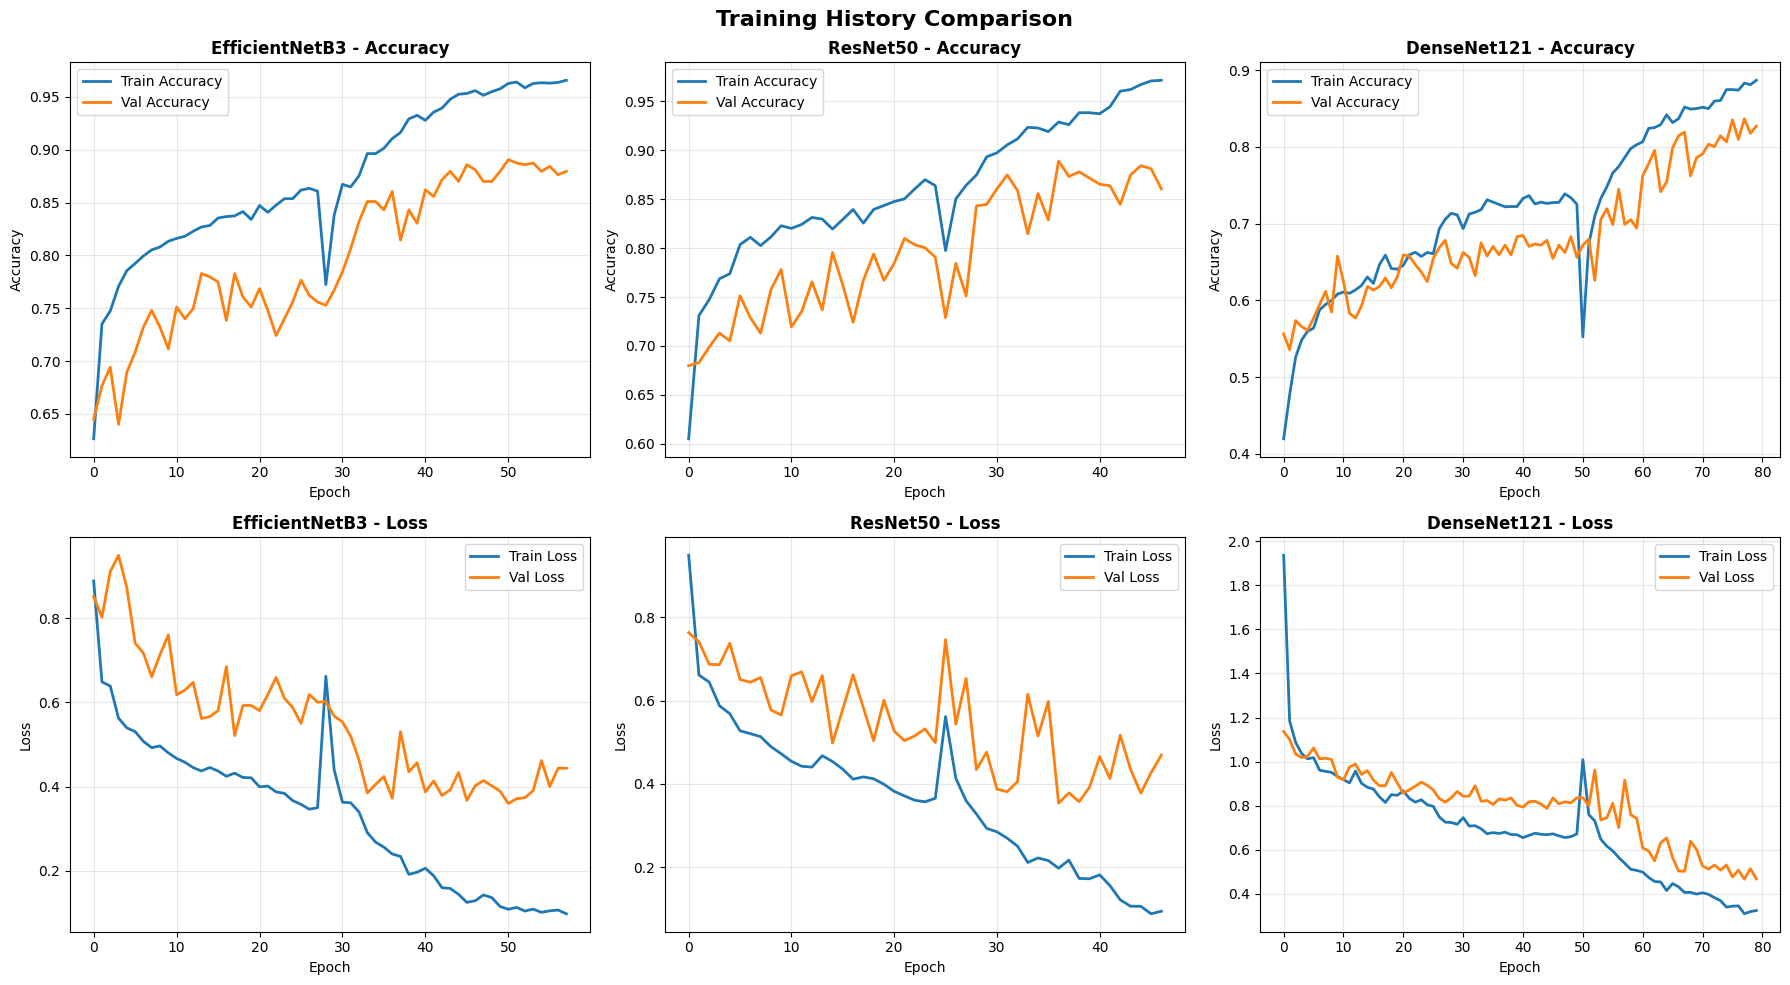

In [41]:
# ========================================
# STEP 11: VISUALIZE TRAINING HISTORY
# ========================================
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Training History Comparison', fontsize=16, fontweight='bold')

for idx, (model_name, result) in enumerate(results.items()):
    history = result['history']
    
    # Accuracy plot
    ax1 = axes[0, idx]
    ax1.plot(history['accuracy'], label='Train Accuracy', linewidth=2)
    ax1.plot(history['val_accuracy'], label='Val Accuracy', linewidth=2)
    ax1.set_title(f'{model_name} - Accuracy', fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Loss plot
    ax2 = axes[1, idx]
    ax2.plot(history['loss'], label='Train Loss', linewidth=2)
    ax2.plot(history['val_loss'], label='Val Loss', linewidth=2)
    ax2.set_title(f'{model_name} - Loss', fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

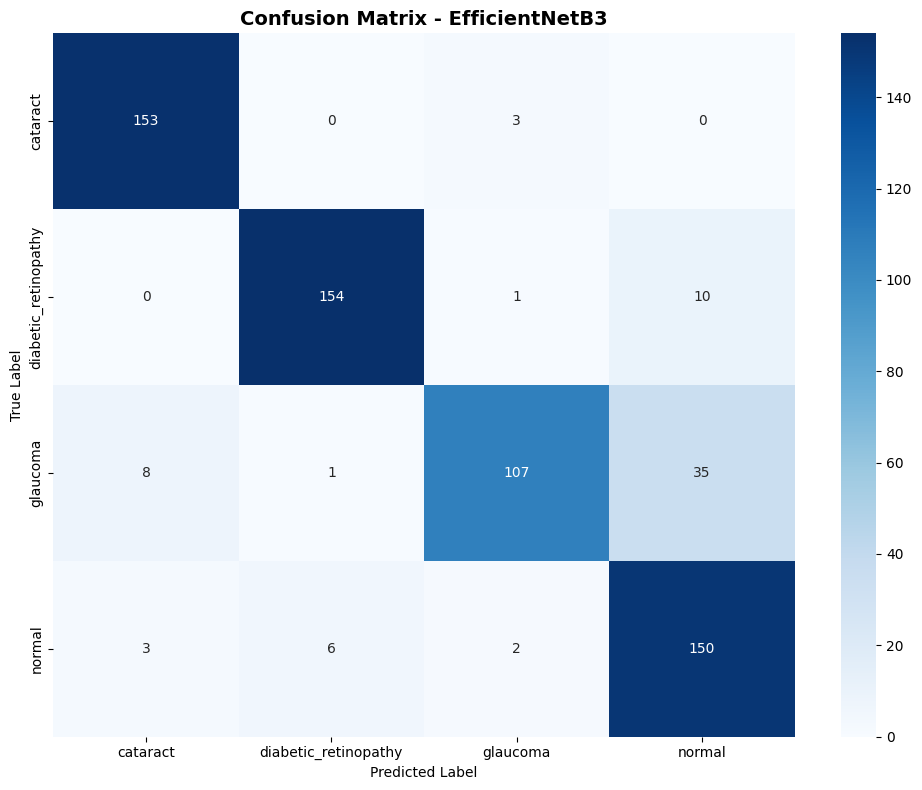


Classification Report:
                      precision    recall  f1-score   support

            cataract       0.93      0.98      0.96       156
diabetic_retinopathy       0.96      0.93      0.94       165
            glaucoma       0.95      0.71      0.81       151
              normal       0.77      0.93      0.84       161

            accuracy                           0.89       633
           macro avg       0.90      0.89      0.89       633
        weighted avg       0.90      0.89      0.89       633



In [48]:
# ========================================
# STEP 12: CONFUSION MATRIX FOR BEST MODEL
# ========================================
best_model = results[best_model_name]['model']

# Get predictions
y_pred = []
y_true = []
for images, labels in test_ds:
    preds = best_model.predict(images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=classes))

In [49]:
# ========================================
# STEP 13: SAVE BEST MODEL + CLASS NAMES
# ========================================
best_model.save(f'final_best_model_{best_model_name}.keras')
print(f"\n✅ Best model saved as: final_best_model_{best_model_name}.keras")

# IMPORTANT: Save class names in the same order for Streamlit
import json
class_mapping = {
    'classes': classes,
    'class_to_idx': class_to_idx,
    'model_name': best_model_name,
    'test_accuracy': float(comparison_df.iloc[0]['Test Accuracy'])
}

with open('class_mapping.json', 'w') as f:
    json.dump(class_mapping, f, indent=4)

print(f"✅ Class mapping saved as: class_mapping.json")
print(f"\nClass order for Streamlit: {classes}")


✅ Best model saved as: final_best_model_EfficientNetB3.keras
✅ Class mapping saved as: class_mapping.json

Class order for Streamlit: ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']


EXPLAINABLE AI (XAI) VISUALIZATION
Model: EfficientNetB3 | Test Accuracy: 89.10%
Sample 1/4: Applying Grad-CAM... Done
Sample 1/4: Applying LIME... 

  0%|          | 0/1000 [00:00<?, ?it/s]

Done
Sample 2/4: Applying Grad-CAM... Done
Sample 2/4: Applying LIME... 

  0%|          | 0/1000 [00:00<?, ?it/s]

Done
Sample 3/4: Applying Grad-CAM... Done
Sample 3/4: Applying LIME... 

  0%|          | 0/1000 [00:00<?, ?it/s]

Done
Sample 4/4: Applying Grad-CAM... Done
Sample 4/4: Applying LIME... 

  0%|          | 0/1000 [00:00<?, ?it/s]

Done


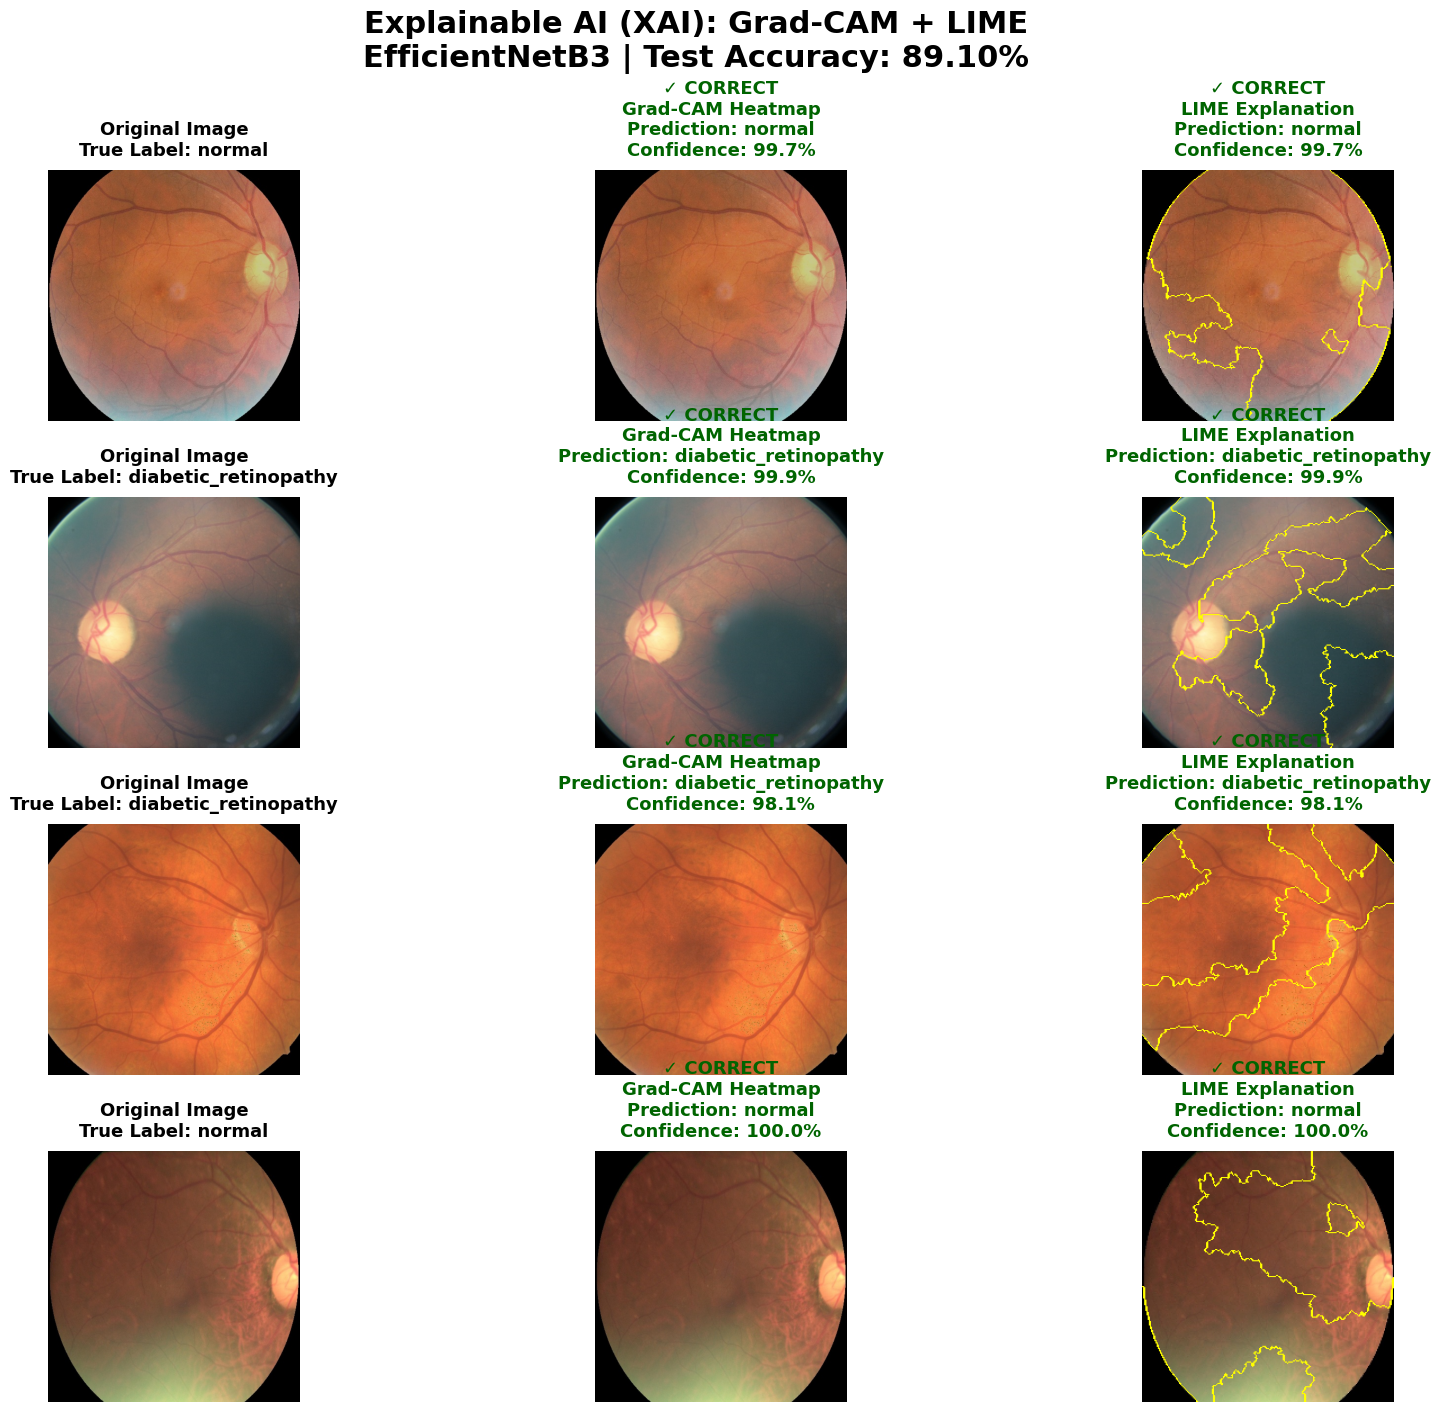


XAI METHODS EXPLANATION

1. GRAD-CAM (Gradient-weighted Class Activation Mapping)
   • Shows WHERE the model focuses in the image
   • Red/Yellow areas = High importance for prediction
   • Blue/Purple areas = Low importance
   • Fast and efficient for medical imaging

2. LIME (Local Interpretable Model-agnostic Explanations)
   • Highlights important REGIONS using superpixels
   • Yellow boundaries = Key regions for classification
   • Model-agnostic (works with any ML model)
   • Better for understanding regional contributions


In [93]:
# ========================================
# STEP 14: EXPLAINABLE AI (Grad-CAM + LIME)
# ========================================

import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow import keras
import tensorflow as tf
import subprocess
import sys

# Install LIME
subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "lime"])
from lime import lime_image
from skimage.segmentation import mark_boundaries

print("="*70)
print("EXPLAINABLE AI (XAI) VISUALIZATION")
print(f"Model: {best_model_name} | Test Accuracy: {results[best_model_name]['test_accuracy']*100:.2f}%")
print("="*70)

# ========================================
# METHOD 1: GRAD-CAM
# ========================================

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """Generate Grad-CAM heatmap"""
    base_model = model.layers[1]
    
    grad_model = keras.Model(
        inputs=model.input,
        outputs=[base_model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    conv_outputs = conv_outputs[0].numpy()
    pooled_grads = pooled_grads.numpy()
    
    for i in range(pooled_grads.shape[0]):
        conv_outputs[:, :, i] *= pooled_grads[i]
    
    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap = heatmap / (heatmap.max() + 1e-10)
    
    return heatmap

def apply_gradcam(img_path, model):
    """Apply Grad-CAM to image"""
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (IMG_SIZE, IMG_SIZE))
    
    img_array = tf.keras.applications.efficientnet.preprocess_input(
        img_resized.astype('float32')
    )
    img_array = np.expand_dims(img_array, axis=0)
    
    preds = model.predict(img_array, verbose=0)
    pred_class = np.argmax(preds[0])
    confidence = preds[0][pred_class]
    
    try:
        heatmap = make_gradcam_heatmap(img_array, model, 'top_activation', pred_class)
        
        heatmap_resized = cv2.resize(heatmap, (img_rgb.shape[1], img_rgb.shape[0]))
        heatmap_colored = np.uint8(255 * heatmap_resized)
        heatmap_colored = cv2.applyColorMap(heatmap_colored, cv2.COLORMAP_JET)
        heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
        
        gradcam_img = cv2.addWeighted(img_rgb, 0.6, heatmap_colored, 0.4, 0)
        
        return img_rgb, gradcam_img, pred_class, confidence, True
    except:
        return img_rgb, img_rgb, pred_class, confidence, False

# ========================================
# METHOD 2: LIME
# ========================================

def apply_lime(img_path, model):
    """Apply LIME to image"""
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (IMG_SIZE, IMG_SIZE))
    
    def predict_fn(images):
        processed = np.array([
            tf.keras.applications.efficientnet.preprocess_input(img.astype('float32'))
            for img in images
        ])
        return model.predict(processed, verbose=0)
    
    explainer = lime_image.LimeImageExplainer()
    
    try:
        explanation = explainer.explain_instance(
            img_resized,
            predict_fn,
            top_labels=1,
            hide_color=0,
            num_samples=1000
        )
        
        preds = predict_fn(np.array([img_resized]))[0]
        pred_class = np.argmax(preds)
        confidence = preds[pred_class]
        
        temp, mask = explanation.get_image_and_mask(
            pred_class,
            positive_only=True,
            num_features=10,
            hide_rest=False
        )
        
        lime_img = mark_boundaries(temp / 255.0, mask)
        lime_img = (lime_img * 255).astype(np.uint8)
        
        return img_rgb, lime_img, pred_class, confidence, True
    except:
        preds = predict_fn(np.array([img_resized]))[0]
        pred_class = np.argmax(preds)
        confidence = preds[pred_class]
        return img_rgb, img_rgb, pred_class, confidence, False

# ========================================
# GENERATE VISUALIZATIONS
# ========================================

sample_indices = np.random.choice(len(X_test), 4, replace=False)

fig = plt.figure(figsize=(20, 16))
gs = fig.add_gridspec(4, 3, hspace=0.3, wspace=0.2)
fig.suptitle(f'Explainable AI (XAI): Grad-CAM + LIME\n{best_model_name} | Test Accuracy: {results[best_model_name]["test_accuracy"]*100:.2f}%', 
             fontsize=22, fontweight='bold', y=0.98)

for row, sample_idx in enumerate(sample_indices):
    img_path = X_test[sample_idx]
    true_label = y_test[sample_idx]
    
    # Original Image
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    ax_orig = fig.add_subplot(gs[row, 0])
    ax_orig.imshow(img_rgb)
    ax_orig.set_title(f'Original Image\nTrue Label: {classes[true_label]}', 
                     fontsize=13, fontweight='bold', pad=10)
    ax_orig.axis('off')
    
    # Grad-CAM
    print(f"Sample {row+1}/4: Applying Grad-CAM...", end=" ")
    _, gradcam_img, pred_class, conf, success = apply_gradcam(img_path, best_model)
    
    ax_gradcam = fig.add_subplot(gs[row, 1])
    ax_gradcam.imshow(gradcam_img)
    is_correct = (pred_class == true_label)
    color = 'darkgreen' if is_correct else 'darkred'
    status = '✓ CORRECT' if is_correct else '✗ WRONG'
    ax_gradcam.set_title(f'{status}\nGrad-CAM Heatmap\nPrediction: {classes[pred_class]}\nConfidence: {conf*100:.1f}%', 
                        fontsize=13, fontweight='bold', color=color, pad=10)
    ax_gradcam.axis('off')
    print("Done")
    
    # LIME
    print(f"Sample {row+1}/4: Applying LIME...", end=" ")
    _, lime_img, pred_class, conf, success = apply_lime(img_path, best_model)
    
    ax_lime = fig.add_subplot(gs[row, 2])
    ax_lime.imshow(lime_img)
    is_correct = (pred_class == true_label)
    color = 'darkgreen' if is_correct else 'darkred'
    status = '✓ CORRECT' if is_correct else '✗ WRONG'
    ax_lime.set_title(f'{status}\nLIME Explanation\nPrediction: {classes[pred_class]}\nConfidence: {conf*100:.1f}%', 
                     fontsize=13, fontweight='bold', color=color, pad=10)
    ax_lime.axis('off')
    print("Done")

plt.tight_layout()
plt.show()

# Method descriptions
print("\n" + "="*70)
print("XAI METHODS EXPLANATION")
print("="*70)
print("\n1. GRAD-CAM (Gradient-weighted Class Activation Mapping)")
print("   • Shows WHERE the model focuses in the image")
print("   • Red/Yellow areas = High importance for prediction")
print("   • Blue/Purple areas = Low importance")
print("   • Fast and efficient for medical imaging")
print("\n2. LIME (Local Interpretable Model-agnostic Explanations)")
print("   • Highlights important REGIONS using superpixels")
print("   • Yellow boundaries = Key regions for classification")
print("   • Model-agnostic (works with any ML model)")
print("   • Better for understanding regional contributions")